## 데이터 파악

In [1]:
# 라이브러리 임포트
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import autograd
from torch.utils import data
from torch.optim import Adam
from torchvision import datasets, transforms
import torchvision.models as models

In [2]:
# 난수 생성기가 항상 일정한 값을 출력하게 하기 위해 seed 고정
random_seed = 2021
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/timeseries/data'

In [53]:
train = pd.read_csv(os.path.join(DATASET_PATH, 'train.csv'))
train

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200101,0,83247,19128,2611,5161,1588,892,32263,1636,7938,1894,14957,3527,11174,2930,8640,14175,2035,5231,18492,48520,15393,16628,8804,2790,38657,1311,3482,11299,7072,1176,3810,748,3920,2133,3799
1,20200101,1,89309,19027,3337,5502,1650,1043,35609,1644,9896,1967,14682,3420,13884,3062,8349,15654,2417,5483,15283,57904,15834,19785,8483,3381,45759,1162,3849,13180,8771,1283,3763,782,3483,2057,4010
2,20200101,2,66611,14710,2970,4631,1044,921,26821,1104,9343,1838,11120,3587,17141,3255,7025,12520,1859,5058,14327,53876,13866,24501,8167,2670,27425,768,2299,7986,5426,1536,3229,491,2634,1526,3388
3,20200101,3,53290,13753,2270,4242,1021,790,21322,909,10009,1630,9836,3842,20715,2661,7226,9821,1724,4863,12787,51615,13528,28695,9459,2325,18893,632,1716,5703,3156,1104,2882,431,2488,1268,3686
4,20200101,4,52095,17615,2406,3689,1840,922,22711,1354,15497,1264,10668,4559,28308,2894,8201,9038,960,5166,11479,47424,18156,26977,10944,3583,18135,875,2421,5816,2933,1206,2433,499,2952,1927,5608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,20200517,19,311727,101285,10085,30637,10060,8749,148935,6801,26101,9370,74169,17764,34715,19806,42734,63382,14130,34866,71475,96849,79150,25109,14680,10465,128344,6726,15431,25597,14292,9300,22238,3786,16936,10729,20194
3275,20200517,20,305354,91426,8607,26021,8095,7198,136503,6147,20759,8432,68923,14593,30279,17634,37661,57815,13055,31943,65378,92116,72379,23165,11879,9135,131682,5501,15378,24661,14747,8239,20604,3203,15018,9767,17962
3276,20200517,21,306008,75113,6325,19933,5711,4494,129412,5134,14496,6739,54455,11997,27047,15943,29029,54627,12292,27424,60696,83628,57866,16629,8573,6488,127826,4216,12558,22781,14081,6392,17937,2447,12403,7825,14031
3277,20200517,22,237447,49498,4209,12145,3891,2718,96698,3526,9363,4543,35618,7996,19478,10010,18663,39694,8818,17770,45983,57321,35250,10761,5331,4109,94288,2578,8870,16640,11066,4427,11955,1495,7507,5387,8889


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 8))
plt.plot(train.iloc[:, 2:])

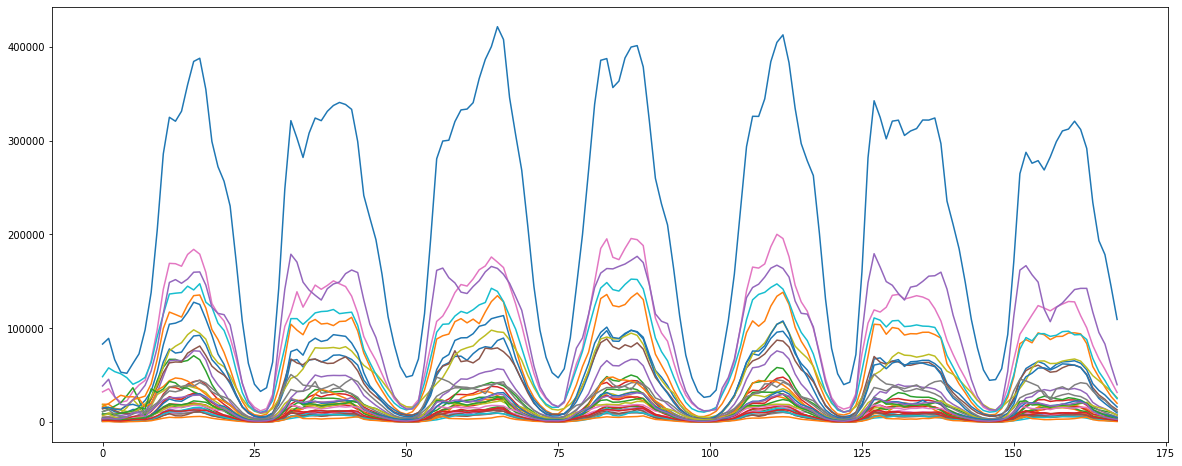

In [7]:
plt.figure(figsize=(20, 8))
plt.plot(train.iloc[:168, 2:])  # 일단위로 주기 보임, 도로들끼리도 어느정도 비슷한 것 같음

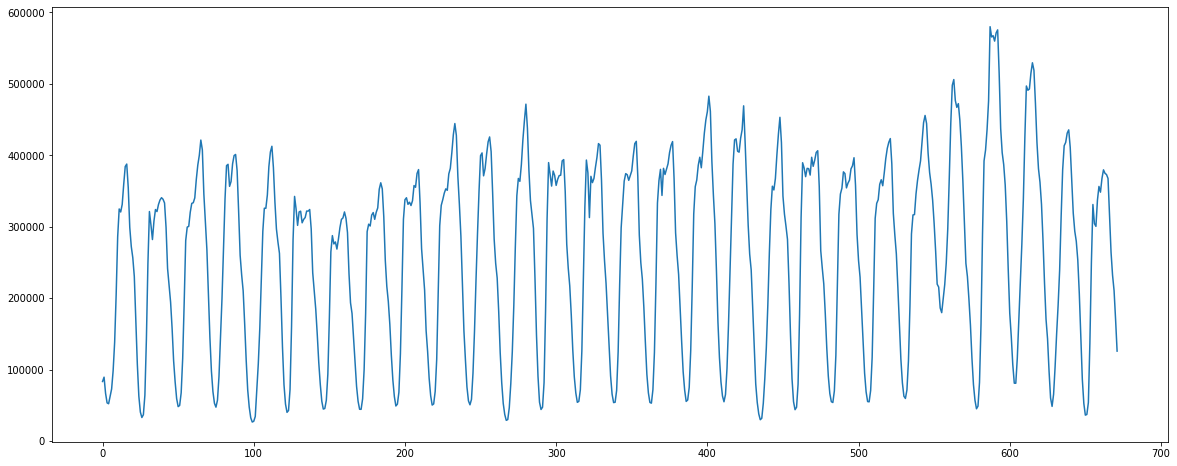

In [8]:
plt.figure(figsize=(20, 8))
plt.plot(train.iloc[:672, 2])  # 설날 통행량 엄청 많음

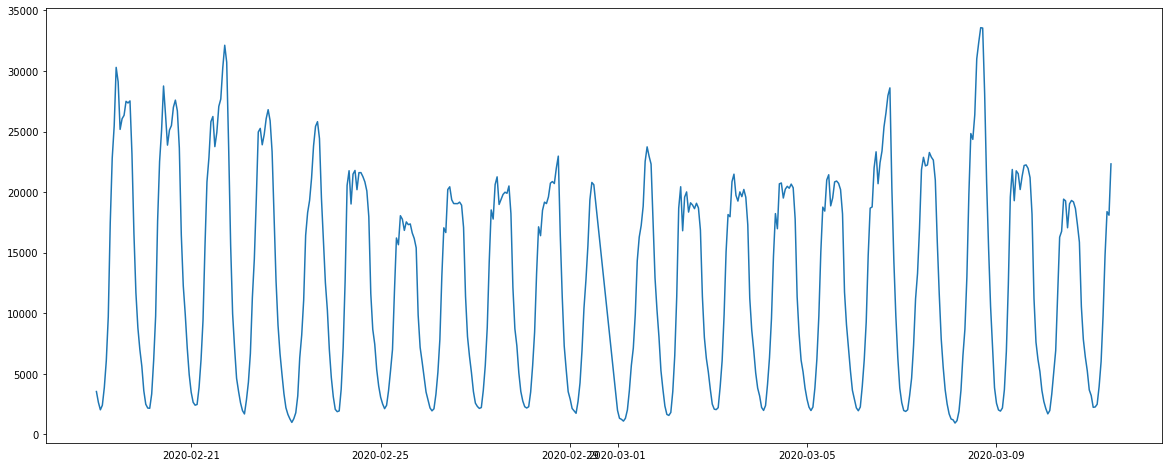

In [31]:
plt.figure(figsize=(20, 8))
plt.plot(train.iloc[1176:1680, -1], train.iloc[1176:1680, 3])

In [55]:
valid = pd.read_csv(os.path.join(DATASET_PATH, 'validate.csv'))
valid

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200511,0,77968,14429,1233,4021,981,881,28672,1064,2859,1549,12036,3225,7324,2789,5907,11097,2641,5396,20709,20787,8429,3184,2055,1430,27798,637,2604,5239,4168,1155,3596,337,2262,1608,2337
1,20200511,1,48679,9136,823,2618,654,572,17722,672,1940,1133,8316,2096,4423,1778,4028,7105,1773,3532,13160,13035,5459,1741,1230,859,16145,353,1870,3359,2558,1002,2157,257,1425,1018,1810
2,20200511,2,33773,8199,578,2188,392,502,14464,579,1425,1211,6623,2168,3693,1642,3376,5290,1268,3085,10377,10477,4610,1070,967,752,12335,345,1499,2646,2022,876,1959,232,1155,927,1530
3,20200511,3,41511,9986,726,2817,555,646,17793,650,1678,1748,7857,2593,4378,1637,4389,6325,1642,3983,11258,13014,5047,1289,1028,1129,14189,390,1730,3398,1967,912,2462,281,1477,959,1882
4,20200511,4,78680,19509,1463,4720,825,1088,35125,997,2531,2304,12197,4013,7034,3207,6514,13898,3185,8286,18038,27303,9132,2202,1599,1609,32976,679,2958,7369,4120,1569,4568,577,3155,1871,3656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,20200524,19,314226,98345,10625,28618,8316,6684,141675,6619,23535,8572,67748,16791,33325,19124,42183,63229,13163,35383,73188,100849,84286,26458,15572,10341,139827,8254,16118,23304,14082,8447,21694,2180,15746,10903,21014
332,20200524,20,300001,87871,8226,22706,6981,5743,142933,6295,20953,7851,61609,14119,30216,18610,35556,59070,12788,30675,68255,95107,76441,24140,13340,8872,142469,5225,15297,21919,14526,7332,19732,1990,14096,10028,17787
333,20200524,21,304150,71126,6002,18317,4939,3779,133110,4781,15242,6101,48336,11534,25710,15651,27467,53787,12019,26317,61169,86434,61136,21076,9317,6392,138816,4072,12685,21135,14403,5443,16967,1359,11670,7963,14041
334,20200524,22,236751,44947,3575,11455,3135,2536,98582,3267,8849,4553,33607,8069,18293,9723,16602,38615,8703,17694,47609,58492,37501,12090,5901,3938,100767,2489,8093,14427,10914,3861,11397,859,7270,5194,8230


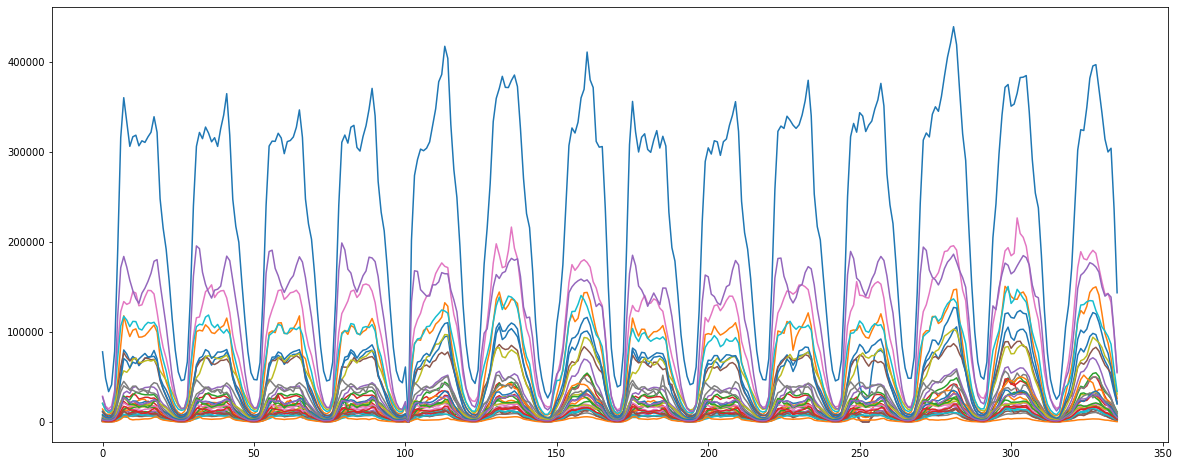

In [10]:
plt.figure(figsize=(20, 8))
plt.plot(valid.iloc[:, 2:])

In [56]:
test = pd.read_csv(os.path.join(DATASET_PATH, 'test.csv'))
test

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200518,0,82065,15172,1500,3294,1086,962,28931,1103,3014,1619,12596,3060,7383,2958,5829,11297,2890,5694,19553,18919,9907,2912,1884,1112,28189,618,2790,5147,4331,1329,3665,404,2242,1619,2314
1,20200518,1,51248,9840,813,2356,696,546,17888,720,1839,1502,7741,2132,4790,1743,4296,6781,1752,3651,12454,11849,6292,1750,1118,703,16683,430,1864,3269,2561,921,2081,272,1390,1003,1766
2,20200518,2,39026,7894,760,2413,408,549,13357,498,1360,1233,6475,2098,3965,1345,3957,4762,1250,3199,9640,9392,4961,1104,1004,485,11934,322,1313,2765,1931,920,1764,228,1136,922,1309
3,20200518,3,40993,10137,780,2701,420,741,15544,532,1671,1800,7720,2133,4083,1501,3992,6202,1505,4459,10802,11664,6015,1132,1061,851,13458,326,1766,3320,2060,892,2447,337,1495,975,1912
4,20200518,4,77863,19603,1276,5019,968,1160,32101,968,2574,2384,12018,3502,6430,2882,5957,11987,3176,9054,16490,23479,10676,1945,1520,1420,31698,669,2914,6986,3911,1368,4380,513,2940,1758,3629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,20200531,19,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
332,20200531,20,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
333,20200531,21,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
334,20200531,22,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [12]:
# !pip install pystan==2.19.1.1

In [13]:
# !pip install fbprophet==0.7.0

In [14]:
# !pip install plotly

In [12]:
from fbprophet import Prophet

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3279 entries, 0 to 3278
Data columns (total 37 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   날짜      3279 non-null   int64
 1   시간      3279 non-null   int64
 2   10      3279 non-null   int64
 3   100     3279 non-null   int64
 4   101     3279 non-null   int64
 5   120     3279 non-null   int64
 6   121     3279 non-null   int64
 7   140     3279 non-null   int64
 8   150     3279 non-null   int64
 9   160     3279 non-null   int64
 10  200     3279 non-null   int64
 11  201     3279 non-null   int64
 12  251     3279 non-null   int64
 13  270     3279 non-null   int64
 14  300     3279 non-null   int64
 15  301     3279 non-null   int64
 16  351     3279 non-null   int64
 17  352     3279 non-null   int64
 18  370     3279 non-null   int64
 19  400     3279 non-null   int64
 20  450     3279 non-null   int64
 21  500     3279 non-null   int64
 22  550     3279 non-null   int64
 23  600     3279 

In [57]:
train['날짜'] = train['날짜'].astype(str)
train['ds'] = pd.to_datetime(train['날짜']) + pd.to_timedelta(train['시간'], unit='h')
train['ds']

0      2020-01-01 00:00:00
1      2020-01-01 01:00:00
2      2020-01-01 02:00:00
3      2020-01-01 03:00:00
4      2020-01-01 04:00:00
               ...        
3274   2020-05-17 19:00:00
3275   2020-05-17 20:00:00
3276   2020-05-17 21:00:00
3277   2020-05-17 22:00:00
3278   2020-05-17 23:00:00
Name: ds, Length: 3279, dtype: datetime64[ns]

In [18]:
train

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000,ds
0,20200101,0,83247,19128,2611,5161,1588,892,32263,1636,7938,1894,14957,3527,11174,2930,8640,14175,2035,5231,18492,48520,15393,16628,8804,2790,38657,1311,3482,11299,7072,1176,3810,748,3920,2133,3799,2020-01-01 00:00:00
1,20200101,1,89309,19027,3337,5502,1650,1043,35609,1644,9896,1967,14682,3420,13884,3062,8349,15654,2417,5483,15283,57904,15834,19785,8483,3381,45759,1162,3849,13180,8771,1283,3763,782,3483,2057,4010,2020-01-01 01:00:00
2,20200101,2,66611,14710,2970,4631,1044,921,26821,1104,9343,1838,11120,3587,17141,3255,7025,12520,1859,5058,14327,53876,13866,24501,8167,2670,27425,768,2299,7986,5426,1536,3229,491,2634,1526,3388,2020-01-01 02:00:00
3,20200101,3,53290,13753,2270,4242,1021,790,21322,909,10009,1630,9836,3842,20715,2661,7226,9821,1724,4863,12787,51615,13528,28695,9459,2325,18893,632,1716,5703,3156,1104,2882,431,2488,1268,3686,2020-01-01 03:00:00
4,20200101,4,52095,17615,2406,3689,1840,922,22711,1354,15497,1264,10668,4559,28308,2894,8201,9038,960,5166,11479,47424,18156,26977,10944,3583,18135,875,2421,5816,2933,1206,2433,499,2952,1927,5608,2020-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,20200517,19,311727,101285,10085,30637,10060,8749,148935,6801,26101,9370,74169,17764,34715,19806,42734,63382,14130,34866,71475,96849,79150,25109,14680,10465,128344,6726,15431,25597,14292,9300,22238,3786,16936,10729,20194,2020-05-17 19:00:00
3275,20200517,20,305354,91426,8607,26021,8095,7198,136503,6147,20759,8432,68923,14593,30279,17634,37661,57815,13055,31943,65378,92116,72379,23165,11879,9135,131682,5501,15378,24661,14747,8239,20604,3203,15018,9767,17962,2020-05-17 20:00:00
3276,20200517,21,306008,75113,6325,19933,5711,4494,129412,5134,14496,6739,54455,11997,27047,15943,29029,54627,12292,27424,60696,83628,57866,16629,8573,6488,127826,4216,12558,22781,14081,6392,17937,2447,12403,7825,14031,2020-05-17 21:00:00
3277,20200517,22,237447,49498,4209,12145,3891,2718,96698,3526,9363,4543,35618,7996,19478,10010,18663,39694,8818,17770,45983,57321,35250,10761,5331,4109,94288,2578,8870,16640,11066,4427,11955,1495,7507,5387,8889,2020-05-17 22:00:00


In [58]:
train = train.drop(columns=['날짜', '시간'])

In [59]:
train.columns

Index(['10', '100', '101', '120', '121', '140', '150', '160', '200', '201',
       '251', '270', '300', '301', '351', '352', '370', '400', '450', '500',
       '550', '600', '650', '652', '1000', '1020', '1040', '1100', '1200',
       '1510', '2510', '3000', '4510', '5510', '6000', 'ds'],
      dtype='object')

In [60]:
holidays = pd.DataFrame({
  'holiday': 'holiday',
  'ds': pd.to_datetime(['2020-01-01', '2020-01-24', '2020-01-25',
                        '2020-01-26', '2020-01-27', '2020-04-15', 
                        '2020-04-30', '2020-05-01', '2020-05-05']),
  'lower_window' : -1,
  'upper_window' : 1
})

In [63]:
df = pd.DataFrame()
df['ds'] = train['ds']

pred = pd.DataFrame()

for i in range(35):
  df['y'] = train.iloc[:, i]

  m = Prophet(holidays=holidays)  # changepoint_prior_scale=0.1
  # m.add_seasonality(name='monthly', period=30, fourier_order=5)
  m.fit(df)

  future = m.make_future_dataframe(freq='H', periods=168)
  forecast = m.predict(future)
  result = forecast[['ds', 'yhat']]
  
  pred[str(i)] = result['yhat']

pred['ds'] = future
pred

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,ds
0,57798.443153,15536.325301,2861.853780,6443.791166,2239.635865,1391.107882,25079.941067,1711.957140,7920.551544,2169.209778,11192.144893,5050.429171,14058.121939,3602.783231,14194.779688,5203.778333,183.335753,2467.149919,21503.143789,22366.288760,16720.345690,9430.119922,7401.278387,3313.258721,14132.325204,798.529183,1922.459319,4308.705157,4193.903433,2214.723032,3402.151161,1089.987690,2136.757620,555.596946,2745.416900,2020-01-01 00:00:00
1,24502.339297,8848.501800,2329.255814,5207.545075,1713.561313,1098.131333,12284.851885,1280.161535,7019.193664,1706.844161,6835.978767,3863.116368,11824.574064,2601.317105,11983.987921,826.760106,-737.534145,682.983861,14916.531981,13990.307913,12882.990902,8229.942945,6602.971446,2700.819906,-2761.589880,376.517116,626.119896,480.327790,1774.711502,1787.085223,2157.959451,962.484183,1306.715603,-157.411142,1624.342802,2020-01-01 01:00:00
2,4677.517571,4774.136558,1979.585590,4697.485227,1049.650199,817.958024,6635.810020,967.102407,6502.008897,1674.527210,4176.324889,3601.208676,11199.280662,2161.702779,11036.144444,-1501.152696,-1092.298313,-29.980248,12126.167660,9734.893216,10308.197341,7848.929337,6046.194799,2324.543036,-13501.871021,-104.388795,-335.907424,-2510.370641,-68.799165,1707.094239,1317.804806,674.295279,50.175922,-920.012378,557.556414,2020-01-01 02:00:00
3,9200.475892,6726.019819,2080.367386,5190.312026,782.288784,754.729749,11047.983846,982.751564,6704.318857,2019.477582,4086.644445,4308.516319,12317.622517,2466.784069,11589.483188,-408.829862,-628.467201,1161.805125,13688.294281,12933.263323,10566.476849,8191.940735,6023.577196,2599.748456,-10441.933780,-252.028613,-185.286299,-1934.647589,-32.599810,1913.486205,1338.345517,478.420944,-389.510940,-1022.653936,661.896792,2020-01-01 03:00:00
4,42838.730514,16579.353416,2800.467912,6742.490671,1495.876668,1109.933678,25535.787739,1497.303244,7729.548195,2556.110046,7743.652480,5598.107856,14397.227701,3581.857384,13571.488456,5133.360588,701.276899,4626.957976,18412.978333,25217.943368,15288.191228,8976.802703,6718.846490,3641.744733,11527.788489,348.887637,1736.518032,4025.456749,2758.558416,2247.335647,2656.623325,710.820584,1435.295322,164.329473,2852.938322,2020-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3442,301775.982906,90424.008691,9611.707811,26102.841645,9332.070482,7336.179002,133795.876022,6091.774866,18984.465258,8311.597050,67292.533358,16240.911490,30443.279009,19212.901615,40104.824191,57366.030592,12004.121282,28344.562962,66960.743044,96490.771785,72218.715950,22474.911091,14879.652763,8521.298182,143684.567578,7166.128135,14672.425164,35148.425706,17147.898704,7969.711217,21862.004220,3385.746704,15843.123156,10563.141113,18588.556635,2020-05-24 19:00:00
3443,259858.470886,70784.135169,7088.634344,20429.010094,6695.072190,5498.961446,113933.896691,4787.740555,14802.687433,6687.838307,55075.772434,12984.871489,25364.729281,15356.753971,32339.841622,47021.935343,10193.832442,22333.170653,58868.379662,79026.053363,56531.235695,18530.384037,11115.550501,6169.481225,122344.763583,5111.006726,12197.092006,28206.189925,14649.698783,6673.910010,17420.771338,2320.378274,11466.868709,7757.813204,13402.539436,2020-05-24 20:00:00
3444,219036.103687,54207.455773,5221.552758,16197.604075,4525.111246,4024.167777,95992.440806,3679.456181,11490.144440,5389.382871,44024.599888,10462.209495,21567.001455,12242.959981,25931.354409,37544.043841,8570.627188,17435.459603,51533.961990,62262.652132,43057.146428,15116.039734,8329.537216,4500.588265,97812.783769,3491.010452,9587.022344,21092.668632,11743.348390,5653.386589,13653.969952,1357.025539,7326.828260,5416.476828,9115.791698,2020-05-24 21:00:00
3445,181508.733683,42625.531706,4095.689655,13374.738568,3239.596708,3124.831829,79449.165357,2890.929480,9304.

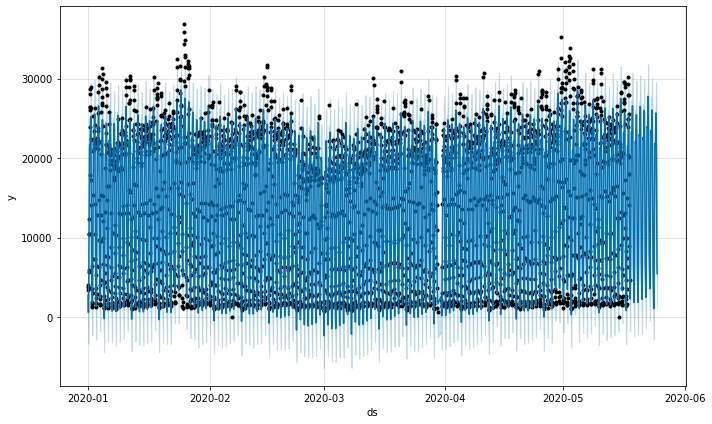

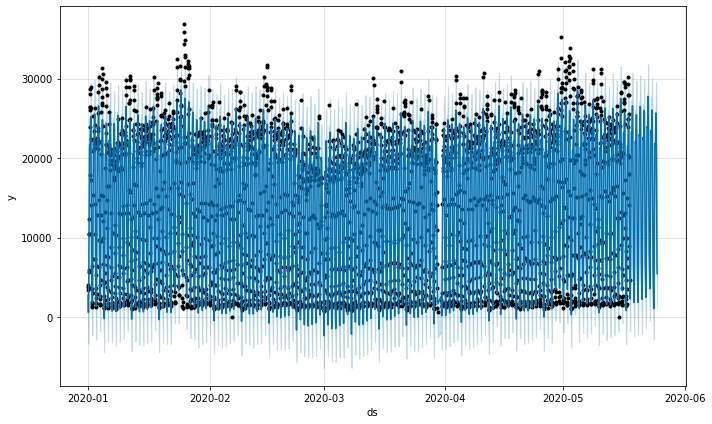

In [64]:
m.plot(forecast)

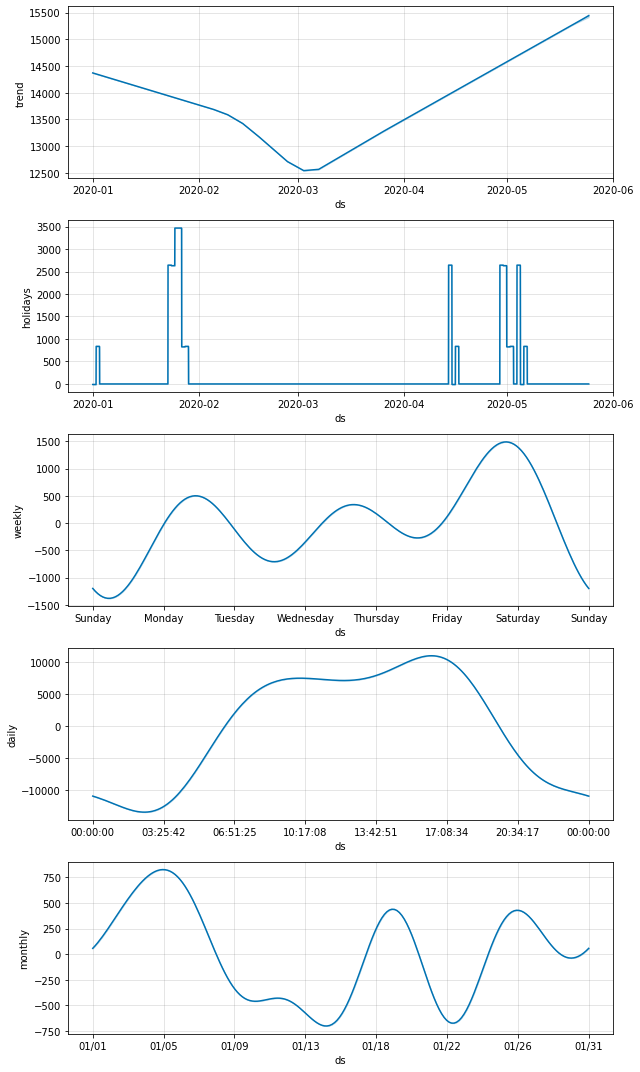

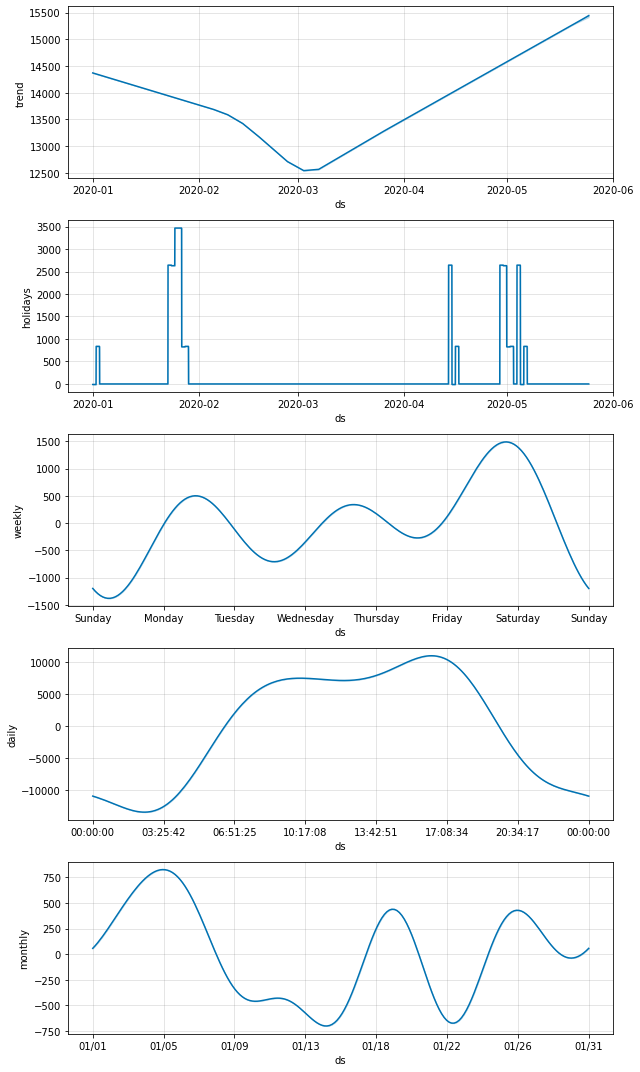

In [46]:
m.plot_components(forecast)

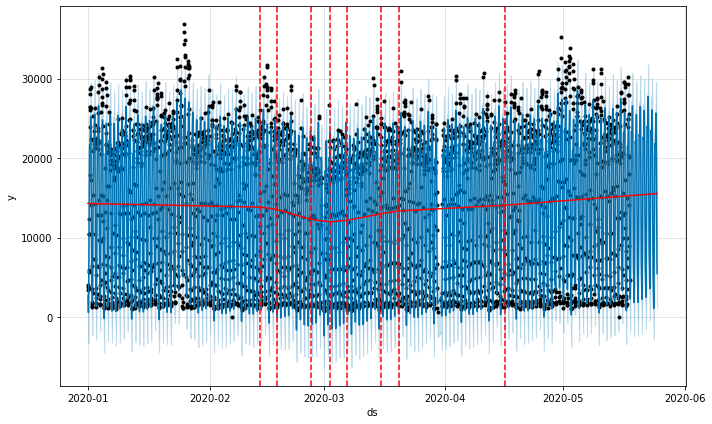

In [65]:
from fbprophet.plot import add_changepoints_to_plot

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [66]:
pred.columns = train.columns
pred.columns

Index(['10', '100', '101', '120', '121', '140', '150', '160', '200', '201',
       '251', '270', '300', '301', '351', '352', '370', '400', '450', '500',
       '550', '600', '650', '652', '1000', '1020', '1040', '1100', '1200',
       '1510', '2510', '3000', '4510', '5510', '6000', 'ds'],
      dtype='object')

In [67]:
# rmse 구하기

pred_ = pred.iloc[-336:, :-1].reset_index(drop=True)
valid_ = valid.iloc[:, 2:].astype(float)

display(pred_, valid_)

,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,102882.177896,23128.831832,2229.118176,7290.641504,2044.511474,1936.106259,42958.062499,1599.100296,5555.733992,2267.421045,18725.148265,4647.970670,10572.837438,5791.222748,11319.969617,18190.654597,4357.891018,8627.168021,24746.415057,25949.545811,16804.922453,6446.292413,3542.899310,2177.923593,37693.133053,1488.472335,4087.436653,9266.950563,4962.919110,2689.526339,6583.910774,784.475370,3040.706399,2717.299756,4139.248995
1,70030.073188,16469.140063,1656.258661,5887.452700,1496.893868,1618.127357,29581.152135,1159.963525,4447.903534,1798.334567,14239.280734,3382.883646,8171.070556,4716.328391,8832.867956,13792.609559,3415.201861,6918.799122,18331.570542,17413.225605,12676.372995,4837.124607,2594.763810,1524.333966,21581.248905,1076.868091,2847.944879,5751.818726,2715.226750,2170.268796,5328.757528,666.750156,2307.733755,2059.217897,3047.558891
2,50475.462395,12391.794802,1264.276461,5204.979862,810.969396,1311.248205,23296.669566,837.541755,3722.538273,1755.342480,11427.315052,3037.226808,7366.615965,4196.747885,7595.299962,11408.572112,3032.465034,6262.427802,15676.476523,12957.423522,9788.048470,4049.600771,1888.619805,1104.077691,11572.436417,603.865666,1937.507882,3063.169645,1040.580855,1997.078438,4466.560160,387.641666,1142.018228,1347.675702,2002.701029
3,55097.295329,14310.269703,1320.936120,5521.001659,521.187987,1219.758692,27023.247584,841.916935,3716.229280,2085.812836,11163.670885,3655.317324,8296.422115,4415.820808,7847.405960,12410.491882,3462.477515,7491.582289,17337.942489,15916.338481,9712.225508,3990.470787,1717.721735,1332.793780,15308.955070,461.604570,2134.237052,3927.926957,1242.065471,2109.173047,4454.229505,200.066901,786.481947,1291.979414,2121.519428
4,88667.374791,24100.802775,1995.363659,6893.092563,1212.024508,1545.310553,40779.259276,1343.413394,4533.655216,2604.347005,14626.260518,4850.773252,10179.756278,5439.397273,9518.631230,17829.197653,4752.927016,10975.073580,22126.969811,27923.917547,14081.226899,4379.373268,2266.408110,2326.133850,37896.829459,1065.390312,4096.512161,10162.453681,4194.065207,2348.103091,5729.172101,439.914122,2688.434216,2521.606700,4319.685134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,301775.982906,90424.008691,9611.707811,26102.841645,9332.070482,7336.179002,133795.876022,6091.774866,18984.465258,8311.597050,67292.533358,16240.911490,30443.279009,19212.901615,40104.824191,57366.030592,12004.121282,28344.562962,66960.743044,96490.771785,72218.715950,22474.911091,14879.652763,8521.298182,143684.567578,7166.128135,14672.425164,35148.425706,17147.898704,7969.711217,21862.004220,3385.746704,15843.123156,10563.141113,18588.556635
332,259858.470886,70784.135169,7088.634344,20429.010094,6695.072190,5498.961446,113933.896691,4787.740555,14802.687433,6687.838307,55075.772434,12984.871489,25364.729281,15356.753971,32339.841622,47021.935343,10193.832442,22333.170653,58868.379662,79026.053363,56531.235695,18530.384037,11115.550501,6169.481225,122344.763583,5111.006726,12197.092006,28206.189925,14649.698783,6673.910010,17420.771338,2320.378274,11466.868709,7757.813204,13402.539436
333,219036.103687,54207.455773,5221.552758,16197.604075,4525.111246,4024.167777,95992.440806,3679.456181,11490.144440,5389.382871,44024.599888,10462.209495,21567.001455,12242.959981,25931.354409,37544.043841,8570.627188,17435.459603,51533.961990,62262.652132,43057.146428,15116.039734,8329.537216,4500.588265,97812.783769,3491.010452,9587.022344,21092.668632,11743.348390,5653.386589,13653.969952,1357.025539,7326.828260,5416.476828,9115.791698
334,181508.733683,42625.531706,4095.689655,13374.738568,3239.596708,3124.831829,79449.165357,2890.929480,9304.961008,4366.697899,34896.824323,8498.601002,18628.818711,9969.499950,21033.508532,29666.656672,716

,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,77968.0,14429.0,1233.0,4021.0,981.0,881.0,28672.0,1064.0,2859.0,1549.0,12036.0,3225.0,7324.0,2789.0,5907.0,11097.0,2641.0,5396.0,20709.0,20787.0,8429.0,3184.0,2055.0,1430.0,27798.0,637.0,2604.0,5239.0,4168.0,1155.0,3596.0,337.0,2262.0,1608.0,2337.0
1,48679.0,9136.0,823.0,2618.0,654.0,572.0,17722.0,672.0,1940.0,1133.0,8316.0,2096.0,4423.0,1778.0,4028.0,7105.0,1773.0,3532.0,13160.0,13035.0,5459.0,1741.0,1230.0,859.0,16145.0,353.0,1870.0,3359.0,2558.0,1002.0,2157.0,257.0,1425.0,1018.0,1810.0
2,33773.0,8199.0,578.0,2188.0,392.0,502.0,14464.0,579.0,1425.0,1211.0,6623.0,2168.0,3693.0,1642.0,3376.0,5290.0,1268.0,3085.0,10377.0,10477.0,4610.0,1070.0,967.0,752.0,12335.0,345.0,1499.0,2646.0,2022.0,876.0,1959.0,232.0,1155.0,927.0,1530.0
3,41511.0,9986.0,726.0,2817.0,555.0,646.0,17793.0,650.0,1678.0,1748.0,7857.0,2593.0,4378.0,1637.0,4389.0,6325.0,1642.0,3983.0,11258.0,13014.0,5047.0,1289.0,1028.0,1129.0,14189.0,390.0,1730.0,3398.0,1967.0,912.0,2462.0,281.0,1477.0,959.0,1882.0
4,78680.0,19509.0,1463.0,4720.0,825.0,1088.0,35125.0,997.0,2531.0,2304.0,12197.0,4013.0,7034.0,3207.0,6514.0,13898.0,3185.0,8286.0,18038.0,27303.0,9132.0,2202.0,1599.0,1609.0,32976.0,679.0,2958.0,7369.0,4120.0,1569.0,4568.0,577.0,3155.0,1871.0,3656.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,314226.0,98345.0,10625.0,28618.0,8316.0,6684.0,141675.0,6619.0,23535.0,8572.0,67748.0,16791.0,33325.0,19124.0,42183.0,63229.0,13163.0,35383.0,73188.0,100849.0,84286.0,26458.0,15572.0,10341.0,139827.0,8254.0,16118.0,23304.0,14082.0,8447.0,21694.0,2180.0,15746.0,10903.0,21014.0
332,300001.0,87871.0,8226.0,22706.0,6981.0,5743.0,142933.0,6295.0,20953.0,7851.0,61609.0,14119.0,30216.0,18610.0,35556.0,59070.0,12788.0,30675.0,68255.0,95107.0,76441.0,24140.0,13340.0,8872.0,142469.0,5225.0,15297.0,21919.0,14526.0,7332.0,19732.0,1990.0,14096.0,10028.0,17787.0
333,304150.0,71126.0,6002.0,18317.0,4939.0,3779.0,133110.0,4781.0,15242.0,6101.0,48336.0,11534.0,25710.0,15651.0,27467.0,53787.0,12019.0,26317.0,61169.0,86434.0,61136.0,21076.0,9317.0,6392.0,138816.0,4072.0,12685.0,21135.0,14403.0,5443.0,16967.0,1359.0,11670.0,7963.0,14041.0
334,236751.0,44947.0,3575.0,11455.0,3135.0,2536.0,98582.0,3267.0,8849.0,4553.0,33607.0,8069.0,18293.0,9723.0,16602.0,38615.0,8703.0,17694.0,47609.0,58492.0,37501.0,12090.0,5901.0,3938.0,100767.0,2489.0,8093.0,14427.0,10914.0,3861.0,11397.0,859.0,7270.0,5194.0,8230.0


In [68]:
error = pred_ - valid_
error

,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,24914.177896,8699.831832,996.118176,3269.641504,1063.511474,1055.106259,14286.062499,535.100296,2696.733992,718.421045,6689.148265,1422.970670,3248.837438,3002.222748,5412.969617,7093.654597,1716.891018,3231.168021,4037.415057,5162.545811,8375.922453,3262.292413,1487.899310,747.923593,9895.133053,851.472335,1483.436653,4027.950563,794.919110,1534.526339,2987.910774,447.475370,778.706399,1109.299756,1802.248995
1,21351.073188,7333.140063,833.258661,3269.452700,842.893868,1046.127357,11859.152135,487.963525,2507.903534,665.334567,5923.280734,1286.883646,3748.070556,2938.328391,4804.867956,6687.609559,1642.201861,3386.799122,5171.570542,4378.225605,7217.372995,3096.124607,1364.763810,665.333966,5436.248905,723.868091,977.944879,2392.818726,157.226750,1168.268796,3171.757528,409.750156,882.733755,1041.217897,1237.558891
2,16702.462395,4192.794802,686.276461,3016.979862,418.969396,809.248205,8832.669566,258.541755,2297.538273,544.342480,4804.315052,869.226808,3673.615965,2554.747885,4219.299962,6118.572112,1764.465034,3177.427802,5299.476523,2480.423522,5178.048470,2979.600771,921.619805,352.077691,-762.563583,258.865666,438.507882,417.169645,-981.419145,1121.078438,2507.560160,155.641666,-12.981772,420.675702,472.701029
3,13586.295329,4324.269703,594.936120,2704.001659,-33.812013,573.758692,9230.247584,191.916935,2038.229280,337.812836,3306.670885,1062.317324,3918.422115,2778.820808,3458.405960,6085.491882,1820.477515,3508.582289,6079.942489,2902.338481,4665.225508,2701.470787,689.721735,203.793780,1119.955070,71.604570,404.237052,529.926957,-724.934529,1197.173047,1992.229505,-80.933099,-690.518053,332.979414,239.519428
4,9987.374791,4591.802775,532.363659,2173.092563,387.024508,457.310553,5654.259276,346.413394,2002.655216,300.347005,2429.260518,837.773252,3145.756278,2232.397273,3004.631230,3931.197653,1567.927016,2689.073580,4088.969811,620.917547,4949.226899,2177.373268,667.408110,717.133850,4920.829459,386.390312,1138.512161,2793.453681,74.065207,779.103091,1161.172101,-137.085878,-466.565784,650.606700,663.685134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,-12450.017094,-7920.991309,-1013.292189,-2515.158355,1016.070482,652.179002,-7879.123978,-527.225134,-4550.534742,-260.402950,-455.466642,-550.088510,-2881.720991,88.901615,-2078.175809,-5862.969408,-1158.878718,-7038.437038,-6227.256956,-4358.228215,-12067.284050,-3983.088909,-692.347237,-1819.701818,3857.567578,-1087.871865,-1445.574836,11844.425706,3065.898704,-477.288783,168.004220,1205.746704,97.123156,-339.858887,-2425.443365
332,-40142.529114,-17086.864831,-1137.365656,-2276.989906,-285.927810,-244.038554,-28999.103309,-1507.259445,-6150.312567,-1163.161693,-6533.227566,-1134.128511,-4851.270719,-3253.246029,-3216.158378,-12048.064657,-2594.167558,-8341.829347,-9386.620338,-16080.946637,-19909.764305,-5609.615963,-2224.449499,-2702.518775,-20124.236417,-113.993274,-3099.907994,6287.189925,123.698783,-658.089990,-2311.228662,330.378274,-2629.131291,-2270.186796,-4384.460564
333,-85113.896313,-16918.544227,-780.447242,-2119.395925,-413.888754,245.167777,-37117.559194,-1101.543819,-3751.855560,-711.617129,-4311.400112,-1071.790505,-4142.998545,-3408.040019,-1535.645591,-16242.956159,-3448.372812,-8881.540397,-9635.038010,-24171.347868,-18078.853572,-5959.960266,-987.462784,-1891.411735,-41003.216231,-580.989548,-3097.977656,-42.331368,-2659.651610,210.386589,-3313.030048,-1.974461,-4343.171740,-2546.523172,-4925.208302
334,-55242.266317,-2321.468294,520.689655,1919.738568,104.596708,588.831829,-19132.834643,-376.070520,455.961008,-186.302101,1289.824323,429.601002,335.818711,246.499950,4431.508532,-8948.343328,-1541.217884,-3703.542951,-3261.746036,-10311.016261,-4231.351244,76.677434,660.057273,-319.394824,-25924.9

In [69]:
squared_error = error**2

In [70]:
squared_error_list = []

for col in squared_error.columns:
  squared_error_list += squared_error[col].values.tolist()

len(squared_error_list)

11760

In [71]:
rmse = np.sqrt(np.mean(squared_error_list))
rmse

8943.478541972638

## train+valid -> test -> submission

In [26]:
train = pd.read_csv(os.path.join(DATASET_PATH, 'train.csv'))
train

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200101,0,83247,19128,2611,5161,1588,892,32263,1636,7938,1894,14957,3527,11174,2930,8640,14175,2035,5231,18492,48520,15393,16628,8804,2790,38657,1311,3482,11299,7072,1176,3810,748,3920,2133,3799
1,20200101,1,89309,19027,3337,5502,1650,1043,35609,1644,9896,1967,14682,3420,13884,3062,8349,15654,2417,5483,15283,57904,15834,19785,8483,3381,45759,1162,3849,13180,8771,1283,3763,782,3483,2057,4010
2,20200101,2,66611,14710,2970,4631,1044,921,26821,1104,9343,1838,11120,3587,17141,3255,7025,12520,1859,5058,14327,53876,13866,24501,8167,2670,27425,768,2299,7986,5426,1536,3229,491,2634,1526,3388
3,20200101,3,53290,13753,2270,4242,1021,790,21322,909,10009,1630,9836,3842,20715,2661,7226,9821,1724,4863,12787,51615,13528,28695,9459,2325,18893,632,1716,5703,3156,1104,2882,431,2488,1268,3686
4,20200101,4,52095,17615,2406,3689,1840,922,22711,1354,15497,1264,10668,4559,28308,2894,8201,9038,960,5166,11479,47424,18156,26977,10944,3583,18135,875,2421,5816,2933,1206,2433,499,2952,1927,5608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,20200517,19,311727,101285,10085,30637,10060,8749,148935,6801,26101,9370,74169,17764,34715,19806,42734,63382,14130,34866,71475,96849,79150,25109,14680,10465,128344,6726,15431,25597,14292,9300,22238,3786,16936,10729,20194
3275,20200517,20,305354,91426,8607,26021,8095,7198,136503,6147,20759,8432,68923,14593,30279,17634,37661,57815,13055,31943,65378,92116,72379,23165,11879,9135,131682,5501,15378,24661,14747,8239,20604,3203,15018,9767,17962
3276,20200517,21,306008,75113,6325,19933,5711,4494,129412,5134,14496,6739,54455,11997,27047,15943,29029,54627,12292,27424,60696,83628,57866,16629,8573,6488,127826,4216,12558,22781,14081,6392,17937,2447,12403,7825,14031
3277,20200517,22,237447,49498,4209,12145,3891,2718,96698,3526,9363,4543,35618,7996,19478,10010,18663,39694,8818,17770,45983,57321,35250,10761,5331,4109,94288,2578,8870,16640,11066,4427,11955,1495,7507,5387,8889


In [27]:
valid = pd.read_csv(os.path.join(DATASET_PATH, 'validate.csv'))
valid

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200511,0,77968,14429,1233,4021,981,881,28672,1064,2859,1549,12036,3225,7324,2789,5907,11097,2641,5396,20709,20787,8429,3184,2055,1430,27798,637,2604,5239,4168,1155,3596,337,2262,1608,2337
1,20200511,1,48679,9136,823,2618,654,572,17722,672,1940,1133,8316,2096,4423,1778,4028,7105,1773,3532,13160,13035,5459,1741,1230,859,16145,353,1870,3359,2558,1002,2157,257,1425,1018,1810
2,20200511,2,33773,8199,578,2188,392,502,14464,579,1425,1211,6623,2168,3693,1642,3376,5290,1268,3085,10377,10477,4610,1070,967,752,12335,345,1499,2646,2022,876,1959,232,1155,927,1530
3,20200511,3,41511,9986,726,2817,555,646,17793,650,1678,1748,7857,2593,4378,1637,4389,6325,1642,3983,11258,13014,5047,1289,1028,1129,14189,390,1730,3398,1967,912,2462,281,1477,959,1882
4,20200511,4,78680,19509,1463,4720,825,1088,35125,997,2531,2304,12197,4013,7034,3207,6514,13898,3185,8286,18038,27303,9132,2202,1599,1609,32976,679,2958,7369,4120,1569,4568,577,3155,1871,3656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,20200524,19,314226,98345,10625,28618,8316,6684,141675,6619,23535,8572,67748,16791,33325,19124,42183,63229,13163,35383,73188,100849,84286,26458,15572,10341,139827,8254,16118,23304,14082,8447,21694,2180,15746,10903,21014
332,20200524,20,300001,87871,8226,22706,6981,5743,142933,6295,20953,7851,61609,14119,30216,18610,35556,59070,12788,30675,68255,95107,76441,24140,13340,8872,142469,5225,15297,21919,14526,7332,19732,1990,14096,10028,17787
333,20200524,21,304150,71126,6002,18317,4939,3779,133110,4781,15242,6101,48336,11534,25710,15651,27467,53787,12019,26317,61169,86434,61136,21076,9317,6392,138816,4072,12685,21135,14403,5443,16967,1359,11670,7963,14041
334,20200524,22,236751,44947,3575,11455,3135,2536,98582,3267,8849,4553,33607,8069,18293,9723,16602,38615,8703,17694,47609,58492,37501,12090,5901,3938,100767,2489,8093,14427,10914,3861,11397,859,7270,5194,8230


In [28]:
train_valid = pd.concat([train, valid])

In [29]:
train_valid['날짜'] = train_valid['날짜'].astype(str)
train_valid['ds'] = pd.to_datetime(train_valid['날짜']) + pd.to_timedelta(train_valid['시간'], unit='h')
train_valid

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000,ds
0,20200101,0,83247,19128,2611,5161,1588,892,32263,1636,7938,1894,14957,3527,11174,2930,8640,14175,2035,5231,18492,48520,15393,16628,8804,2790,38657,1311,3482,11299,7072,1176,3810,748,3920,2133,3799,2020-01-01 00:00:00
1,20200101,1,89309,19027,3337,5502,1650,1043,35609,1644,9896,1967,14682,3420,13884,3062,8349,15654,2417,5483,15283,57904,15834,19785,8483,3381,45759,1162,3849,13180,8771,1283,3763,782,3483,2057,4010,2020-01-01 01:00:00
2,20200101,2,66611,14710,2970,4631,1044,921,26821,1104,9343,1838,11120,3587,17141,3255,7025,12520,1859,5058,14327,53876,13866,24501,8167,2670,27425,768,2299,7986,5426,1536,3229,491,2634,1526,3388,2020-01-01 02:00:00
3,20200101,3,53290,13753,2270,4242,1021,790,21322,909,10009,1630,9836,3842,20715,2661,7226,9821,1724,4863,12787,51615,13528,28695,9459,2325,18893,632,1716,5703,3156,1104,2882,431,2488,1268,3686,2020-01-01 03:00:00
4,20200101,4,52095,17615,2406,3689,1840,922,22711,1354,15497,1264,10668,4559,28308,2894,8201,9038,960,5166,11479,47424,18156,26977,10944,3583,18135,875,2421,5816,2933,1206,2433,499,2952,1927,5608,2020-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,20200524,19,314226,98345,10625,28618,8316,6684,141675,6619,23535,8572,67748,16791,33325,19124,42183,63229,13163,35383,73188,100849,84286,26458,15572,10341,139827,8254,16118,23304,14082,8447,21694,2180,15746,10903,21014,2020-05-24 19:00:00
332,20200524,20,300001,87871,8226,22706,6981,5743,142933,6295,20953,7851,61609,14119,30216,18610,35556,59070,12788,30675,68255,95107,76441,24140,13340,8872,142469,5225,15297,21919,14526,7332,19732,1990,14096,10028,17787,2020-05-24 20:00:00
333,20200524,21,304150,71126,6002,18317,4939,3779,133110,4781,15242,6101,48336,11534,25710,15651,27467,53787,12019,26317,61169,86434,61136,21076,9317,6392,138816,4072,12685,21135,14403,5443,16967,1359,11670,7963,14041,2020-05-24 21:00:00
334,20200524,22,236751,44947,3575,11455,3135,2536,98582,3267,8849,4553,33607,8069,18293,9723,16602,38615,8703,17694,47609,58492,37501,12090,5901,3938,100767,2489,8093,14427,10914,3861,11397,859,7270,5194,8230,2020-05-24 22:00:00


In [30]:
train_valid = train_valid.drop(columns=['날짜', '시간'])

In [31]:
df = pd.DataFrame()
df['ds'] = train_valid['ds']

pred = pd.DataFrame()

for i in range(35):
  df['y'] = train_valid.iloc[:, i]

  m = Prophet(holidays=holidays)
  m.fit(df)

  future = m.make_future_dataframe(freq='H', periods=168)
  forecast = m.predict(future)
  result = forecast[['ds', 'yhat']]
  
  pred[str(i)] = result['yhat']

pred['ds'] = future
pred

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,ds
0,64246.955156,15851.395080,2949.324171,6588.507068,2331.944609,1466.110038,26524.086687,1734.764930,7393.958568,2198.782958,11987.953387,5127.723455,13663.955752,3617.359945,14226.930395,5725.277375,39.028492,2697.857120,22234.643772,22557.196890,16600.090737,8478.369257,6860.997824,3115.495731,14753.367917,889.514683,2007.739740,4349.892026,3819.043850,2291.339259,3449.673391,1149.878260,2165.311842,483.921768,2837.133997,2020-01-01 00:00:00
1,30450.754609,9058.353868,2412.596804,5333.373156,1799.219217,1174.129871,13648.511817,1297.192406,6476.941421,1736.098209,7575.866121,3944.978822,11400.593973,2588.284411,12009.879689,1282.548633,-900.240730,877.999350,15608.140019,14102.903633,12700.947570,7268.415254,6063.541880,2492.358624,-2460.450355,454.465032,683.328413,501.594295,1371.411717,1869.509018,2184.772317,1020.938646,1309.328880,-248.620666,1696.613961,2020-01-01 01:00:00
2,10366.167156,4926.402382,2059.703891,4822.787134,1126.788618,890.528769,8011.850319,980.387728,5950.078534,1704.153316,4881.590871,3689.479296,10760.089819,2140.790795,11059.826879,-1054.520677,-1261.379977,159.262162,12791.102473,9895.947852,10111.493532,6878.909807,5508.248484,2110.634682,-13296.923448,-31.573571,-297.427340,-2486.599360,-497.287914,1792.105712,1340.652659,730.925830,33.309837,-1028.229673,620.536885,2020-01-01 02:00:00
3,15142.364174,6920.182345,2162.292009,5337.478232,858.376794,825.197517,12555.524822,996.742726,6157.569397,2053.668940,4814.906289,4399.495010,11894.021156,2463.924771,11621.968324,138.277369,-773.452633,1407.772161,14389.321432,13292.329710,10420.402909,7216.752268,5492.060130,2392.801518,-9977.729342,-171.531405,-143.237788,-1882.148545,-456.326059,1997.020233,1383.155883,537.032580,-396.166789,-1131.089637,733.530033,2020-01-01 03:00:00
4,49449.717059,16927.606798,2897.505280,6944.366337,1588.055281,1190.324088,27278.771779,1516.909086,7212.689672,2605.024798,8582.928058,5693.338299,14032.060906,3616.462982,13640.364632,5892.982252,618.448793,4988.731941,19229.505533,25835.251020,15262.380080,8018.311725,6208.144644,3456.006426,12524.656118,443.713935,1806.095382,4113.301281,2380.134893,2331.592052,2748.079404,778.083314,1479.189242,81.019874,2952.135467,2020-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3610,299636.163530,89681.780423,8752.727580,25424.749236,9091.794140,6737.689073,127801.779960,6048.315784,19155.323794,7882.001019,63375.952546,13738.681612,28961.534566,16953.451021,36300.537105,53326.084178,12007.451414,29110.093601,65077.794472,88814.655448,72285.681223,20527.065293,13210.313578,8441.003291,143435.436896,6953.039952,14759.274926,23508.463153,17206.531355,7157.366164,21344.904536,2991.093082,17072.678782,10683.148619,18821.011455,2020-05-31 19:00:00
3611,257566.032080,69870.060043,6216.536541,19704.023857,6438.435783,4877.506224,107967.621079,4736.951576,14955.656543,6255.835319,51114.606795,10484.993705,23835.433387,13061.228477,28502.677535,42937.281277,10158.825519,22981.259612,56863.266600,71461.160030,56475.469884,16597.289894,9439.270676,6081.833339,122227.901620,4872.177073,12257.547386,16593.666691,14713.881232,5848.747229,16856.012829,1927.791857,12664.765621,7843.584969,13601.739270,2020-05-31 20:00:00
3612,216740.205697,53168.241386,4331.937466,15405.945790,4248.382384,3375.663806,89971.632208,3623.639099,11600.982174,4944.268114,39998.327657,7953.879136,19972.805623,9922.962483,22035.700807,33368.656169,8487.317315,17997.770993,49426.659787,54758.034824,42862.552597,13168.088889,6635.313051,4402.594422,97740.374127,3245.523764,9634.283061,9497.516613,11813.593565,4806.064870,13049.924375,963.134544,8493.453784,5474.769664,9286.633243,2020-05-31 21:00:00
3613,179269.590697,41490.519629,3186.352701,12506.845764,2946.059982,2454.405747,73286.989438,2830.885654,9364.955

In [32]:
pred.columns = train_valid.columns

In [33]:
pred[-168:].reset_index(drop=True)

,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000,ds
0,104508.658625,24880.570296,1983.229185,8008.784028,1987.774695,1726.068670,40339.102284,1717.982101,6186.751396,2219.739805,17585.049841,3152.439497,10647.920410,4697.981689,10193.721834,14695.166609,4379.034883,9403.078577,25390.013233,20807.050706,19365.359928,5607.829245,2923.521238,2334.760170,36681.232358,1544.373230,4376.624901,1189.021739,4954.254506,2403.374594,6666.707246,414.601875,4099.070318,2934.023525,4521.713167,2020-05-25 00:00:00
1,71072.486750,18071.621597,1398.141856,6569.566255,1427.452015,1402.450156,26804.288531,1269.970284,5047.315160,1744.801336,13011.793341,1875.922037,8195.366605,3580.024075,7669.223189,10203.307336,3415.798631,7642.850199,18911.552393,12135.260052,15143.089982,3962.998227,1959.908267,1664.749239,20176.291497,1115.872198,3106.721584,-2393.290116,2679.755420,1882.443623,5382.536579,294.693677,3339.496265,2252.547490,3403.456385,2020-05-25 01:00:00
2,51178.006607,13893.741601,995.078857,5869.418108,727.161529,1085.603360,20456.638806,940.776163,4296.321138,1696.582200,10134.534258,1521.213156,7354.447904,3037.402771,6398.782969,7781.795720,3024.300042,6963.621465,16206.711145,7671.183833,12209.116183,3141.181394,1238.872951,1233.391545,9999.748010,633.995678,2175.275660,-5125.880603,981.597860,1704.500924,4508.055042,13.036311,2153.514502,1520.312093,2342.443708,2020-05-25 02:00:00
3,55977.475099,15812.485620,1045.978088,6190.255998,430.726344,985.607693,24241.418109,942.917107,4279.301285,2025.984019,9864.205372,2127.165082,8278.402150,3259.694859,6629.625741,8855.786980,3475.784321,8231.597353,17882.005892,10772.041669,12154.004269,3051.223386,1058.021655,1463.501111,13926.003113,495.812286,2373.373057,-4277.912190,1189.531311,1807.946683,4509.390290,-173.253311,1807.297730,1460.904267,2463.343718,2020-05-25 03:00:00
4,90146.140444,25717.017201,1728.291902,7600.215927,1132.327144,1314.855516,38162.188538,1447.189001,5110.845641,2553.605359,13409.311705,3312.710810,10198.634923,4306.266186,8307.888428,14458.652053,4825.532531,11812.280096,22765.235473,22982.691156,16614.533481,3431.361149,1611.170376,2472.584325,36979.421925,1110.477891,4361.076722,1947.480351,4188.492493,2040.623119,5822.739657,74.585589,3758.828656,2712.372101,4682.827352,2020-05-25 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,299636.163530,89681.780423,8752.727580,25424.749236,9091.794140,6737.689073,127801.779960,6048.315784,19155.323794,7882.001019,63375.952546,13738.681612,28961.534566,16953.451021,36300.537105,53326.084178,12007.451414,29110.093601,65077.794472,88814.655448,72285.681223,20527.065293,13210.313578,8441.003291,143435.436896,6953.039952,14759.274926,23508.463153,17206.531355,7157.366164,21344.904536,2991.093082,17072.678782,10683.148619,18821.011455,2020-05-31 19:00:00
164,257566.032080,69870.060043,6216.536541,19704.023857,6438.435783,4877.506224,107967.621079,4736.951576,14955.656543,6255.835319,51114.606795,10484.993705,23835.433387,13061.228477,28502.677535,42937.281277,10158.825519,22981.259612,56863.266600,71461.160030,56475.469884,16597.289894,9439.270676,6081.833339,122227.901620,4872.177073,12257.547386,16593.666691,14713.881232,5848.747229,16856.012829,1927.791857,12664.765621,7843.584969,13601.739270,2020-05-31 20:00:00
165,216740.205697,53168.241386,4331.937466,15405.945790,4248.382384,3375.663806,89971.632208,3623.639099,11600.982174,4944.268114,39998.327657,7953.879136,19972.805623,9922.962483,22035.700807,33368.656169,8487.317315,17997.770993,49426.659787,54758.034824,42862.552597,13168.088889,6635.313051,4402.594422,97740.374127,3245.523764,9634.283061,9497.516613,11813.593565,4806.064870,13049.924375,963.134544,8493.453784,5474.769664,9286.633243,2020-05-31 21:00:00
166,179269.590697,41490.519629,3186.352701,12506.8

In [34]:
sub = pd.read_csv(os.path.join(DATASET_PATH, 'sample_submission.csv'))
sub

,timestamp,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200525_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20200525_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20200525_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20200525_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20200525_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,20200531_19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
164,20200531_20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
165,20200531_21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166,20200531_22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
sub.iloc[:, 1:] = pred[-168:].reset_index(drop=True)
sub

,timestamp,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200525_0,104508.658625,24880.570296,1983.229185,8008.784028,1987.774695,1726.068670,40339.102284,1717.982101,6186.751396,2219.739805,17585.049841,3152.439497,10647.920410,4697.981689,10193.721834,14695.166609,4379.034883,9403.078577,25390.013233,20807.050706,19365.359928,5607.829245,2923.521238,2334.760170,36681.232358,1544.373230,4376.624901,1189.021739,4954.254506,2403.374594,6666.707246,414.601875,4099.070318,2934.023525,4521.713167
1,20200525_1,71072.486750,18071.621597,1398.141856,6569.566255,1427.452015,1402.450156,26804.288531,1269.970284,5047.315160,1744.801336,13011.793341,1875.922037,8195.366605,3580.024075,7669.223189,10203.307336,3415.798631,7642.850199,18911.552393,12135.260052,15143.089982,3962.998227,1959.908267,1664.749239,20176.291497,1115.872198,3106.721584,-2393.290116,2679.755420,1882.443623,5382.536579,294.693677,3339.496265,2252.547490,3403.456385
2,20200525_2,51178.006607,13893.741601,995.078857,5869.418108,727.161529,1085.603360,20456.638806,940.776163,4296.321138,1696.582200,10134.534258,1521.213156,7354.447904,3037.402771,6398.782969,7781.795720,3024.300042,6963.621465,16206.711145,7671.183833,12209.116183,3141.181394,1238.872951,1233.391545,9999.748010,633.995678,2175.275660,-5125.880603,981.597860,1704.500924,4508.055042,13.036311,2153.514502,1520.312093,2342.443708
3,20200525_3,55977.475099,15812.485620,1045.978088,6190.255998,430.726344,985.607693,24241.418109,942.917107,4279.301285,2025.984019,9864.205372,2127.165082,8278.402150,3259.694859,6629.625741,8855.786980,3475.784321,8231.597353,17882.005892,10772.041669,12154.004269,3051.223386,1058.021655,1463.501111,13926.003113,495.812286,2373.373057,-4277.912190,1189.531311,1807.946683,4509.390290,-173.253311,1807.297730,1460.904267,2463.343718
4,20200525_4,90146.140444,25717.017201,1728.291902,7600.215927,1132.327144,1314.855516,38162.188538,1447.189001,5110.845641,2553.605359,13409.311705,3312.710810,10198.634923,4306.266186,8307.888428,14458.652053,4825.532531,11812.280096,22765.235473,22982.691156,16614.533481,3431.361149,1611.170376,2472.584325,36979.421925,1110.477891,4361.076722,1947.480351,4188.492493,2040.623119,5822.739657,74.585589,3758.828656,2712.372101,4682.827352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,20200531_19,299636.163530,89681.780423,8752.727580,25424.749236,9091.794140,6737.689073,127801.779960,6048.315784,19155.323794,7882.001019,63375.952546,13738.681612,28961.534566,16953.451021,36300.537105,53326.084178,12007.451414,29110.093601,65077.794472,88814.655448,72285.681223,20527.065293,13210.313578,8441.003291,143435.436896,6953.039952,14759.274926,23508.463153,17206.531355,7157.366164,21344.904536,2991.093082,17072.678782,10683.148619,18821.011455
164,20200531_20,257566.032080,69870.060043,6216.536541,19704.023857,6438.435783,4877.506224,107967.621079,4736.951576,14955.656543,6255.835319,51114.606795,10484.993705,23835.433387,13061.228477,28502.677535,42937.281277,10158.825519,22981.259612,56863.266600,71461.160030,56475.469884,16597.289894,9439.270676,6081.833339,122227.901620,4872.177073,12257.547386,16593.666691,14713.881232,5848.747229,16856.012829,1927.791857,12664.765621,7843.584969,13601.739270
165,20200531_21,216740.205697,53168.241386,4331.937466,15405.945790,4248.382384,3375.663806,89971.632208,3623.639099,11600.982174,4944.268114,39998.327657,7953.879136,19972.805623,9922.962483,22035.700807,33368.656169,8487.317315,17997.770993,49426.659787,54758.034824,42862.552597,13168.088889,6635.313051,4402.594422,97740.374127,3245.523764,9634.283061,9497.516613,11813.593565,4806.064870,13049.924375,963.134544,8493.453784,5474.769664,9286.633243
166,20200531_22,179269.590697,41490.519629,3186.352701,12506.845764,2946.059982,2454.405747,73286.989438,2830.88

In [36]:
sub.to_csv('prophet_holiday2.csv', index=0)